<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="500" height="auto" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>Chair of Soil Mechanics and Foundation Engineering<br>Geotechnical Institute<br>Technische Universität Bergakademie Freiberg.</p>
        <p><a href="https://tu-freiberg.de/en/soilmechanics">https://tu-freiberg.de/en/soilmechanics</a></p>
    </div>
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

#Some plot settings
import plot_functions.plot_settings
import seaborn as sns

# Connection between capillary rise, pressure and saturation profiles in soils

Deriving the flow law's from thermodynamic principles leads to the following two equations (see Ehlers and Wagner, 2019; Grunwald et al., 2020; others)

\begin{align*}
    \tilde{\mathbf{w}}_\text{GS} &= - \frac{k_\text{rel,G} \mathbf{k}}{\mu_\text{GR}} \left( \text{grad}\,p_\text{GR} - \varrho_\text{GR} \mathbf{b} \right)
    \
    \tilde{\mathbf{w}}_\text{LS} &= - \frac{k_\text{rel,L} \mathbf{k}}{\mu_\text{LR}} \left( \text{grad}\,p_\text{LR} - \varrho_\text{LR} \mathbf{b} - \frac{p_\text{cap}}{S_\text{L}} \text{grad}\,S_\text{L} \right)
\end{align*}

The second term is rarely seen. Here we investigate its physical meaning. For that purpose, we look at the equlibrium distribution of liquid pressure and saturation above a groundwater table for different retention properties. The hypothesis is that the final term leads to a coupling between the pressure and saturation profiles in soils especially for strongly capillary active media.

Our assumptions are:
* Richards approximation: $p_\text{GR} = 0 = \text{const.}$, $p_\text{cap} = - p_\text{LR}$
* Equilibrium: $\tilde{\mathbf{w}}_\text{LS} = 0$
* One-dimensional problem, $z$ points upward and starts at the groundwater table, so that $b=-g$

Hence, we arrive at:

\begin{align*}
    0 &= \text{grad}\,p_\text{LR} + \varrho_\text{LR} g - \frac{p_\text{cap}}{S_\text{L}} \text{grad}\,S_\text{L}
    \
    \frac{\partial p_\text{LR}}{\partial z} &= -\varrho_\text{LR} g - \frac{p_\text{LR}}{S_\text{L}} \frac{\partial S_\text{L}}{\partial z}
\end{align*}

We use a van Genuchten model:

$$
    S_\text{L}= \left[ 1 + \left( \frac{p_\text{cap}}{a} \right)^b \right]^{-c}
$$

For which we require the derivative:

$$
    \frac{\partial S_\text{L}}{\partial p_\text{cap}} = - \frac{cb}{a} \left[1 + \left( \frac{p_\text{cap}}{a} \right)^b \right]^{-c-1} \left( \frac{p_\text{cap}}{a} \right)^{b-1}
$$

We arrive at the following pressure gradient:

$$
    \frac{\partial p_\text{LR}}{\partial z} = -\frac{\gamma_\text{LR}}{1 - \displaystyle\frac{\partial S_\text{L}}{\partial p_\text{cap}} \frac{p_\text{LR}}{S_\text{L}}}
$$

At the groundwater table we set

$$
    p_\text{LR} |_{z=0} = 0
$$

In [2]:
def saturation(pcap,b=1.5,a=5e4):
    c = (1-1/b)
    return 1/np.power(1+np.power(pcap/a,b),c)

def dSat_dpcap(pcap,b=1.5,a=5e4):
    c = (1-1/b)
    term1 = np.power(pcap/a,b-1)
    term12 = 1.+np.power(pcap/a,b)
    term2 = np.power(term12,-c-1)
    return -c*b/a * term1 * term2

In [3]:
def plot_input(b):
    pc=np.logspace(-2,10,1000)
    fig, ax = plt.subplots(ncols=2,figsize=(18,8))

    for i in b:
        ax[0].plot(saturation(pc,i),pc/1000,label=str(i))
        ax[1].plot(saturation(pc,i),-dSat_dpcap(pc,i))
    ax[0].set_yscale('log')
    ax[0].set_xlabel(r'$S_\mathrm{L}$')
    ax[0].set_ylabel(r'$p_\mathrm{cap}$ / kPa')
    ax[0].set_ylim(bottom=0.1)

    
    ax[1].set_yscale('log')
    ax[1].set_xlabel(r'$S_\mathrm{L}$')
    ax[1].set_ylabel(r'$(\partial S_\mathrm{L} / \partial p_\mathrm{cap})$ / Pa$^{-1}$')
    fig.legend()
    fig.tight_layout();

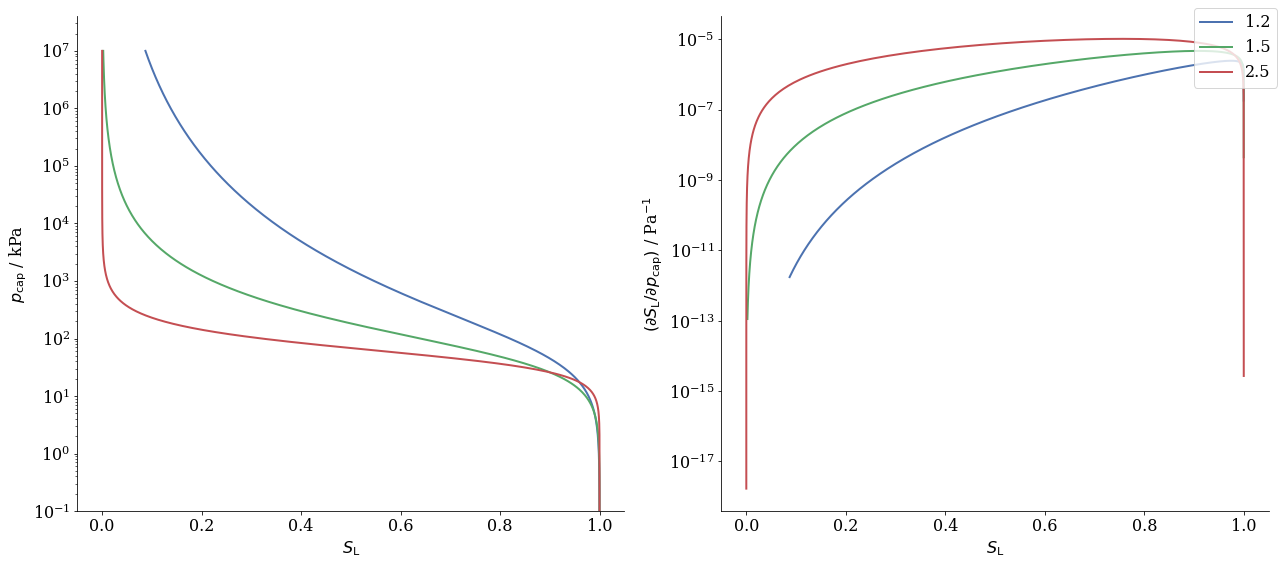

In [4]:
plot_input([1.2, 1.5, 2.5])

In [5]:
epsilon = lambda p: p/1e8

In [6]:
dsat_dp = lambda p0: (saturation(p0 + epsilon(p0)) - saturation(p0 - epsilon(p0)))/(2.*epsilon(p0))

In [7]:
rel_err = lambda p : (dsat_dp(p) - dSat_dpcap(p))/dSat_dpcap(p)

In [8]:
#plt.plot(pc,rel_err(pc))
#plt.title(r'relative error analytical derivative');

Now we use forward finite differences to integrate up the equation.

$$
    \frac{\partial p_\text{LR}}{\partial z} = -\frac{\gamma_\text{LR}}{1 - \displaystyle\frac{\partial S_\text{L}}{\partial p_\text{cap}} \frac{p_\text{LR}}{S_\text{L}}}
$$

We end up with the following explicit update:

$$
    p_\text{LR}(z+\Delta z) \approx p_\text{LR}(z) -\Delta z \frac{\gamma_\text{LR}}{1 - \displaystyle \left. \frac{\partial S_\text{L}}{\partial p_\text{cap}}\right|_z \frac{p_\text{LR}(z)}{S_\text{L}(-p_\text{LR}(z))}}
$$

In [9]:
def Forward_Euler_Update(pLR,dz,b,extension=1):#extension can switch off new term
    gamma_LR = 1000.*9.81
    function = gamma_LR/(1-extension*dSat_dpcap(-pLR,b) * pLR/saturation(-pLR,b))
    return - dz * function

In [21]:
def integrate(b):
    z = np.linspace(0,10,10000)
    liquid_pressure_classic = np.array([-1.e-3])
    liquid_pressure_thermo = np.array([-1.e-3])
    for i in range(1,len(z)):
        update_classic = liquid_pressure_classic[i-1] + Forward_Euler_Update(liquid_pressure_classic[i-1],z[i]-z[i-1],b,0)
        update_thermo = liquid_pressure_thermo[i-1] + Forward_Euler_Update(liquid_pressure_thermo[i-1],z[i]-z[i-1],b,1)
        liquid_pressure_classic = np.append(liquid_pressure_classic,update_classic)
        liquid_pressure_thermo = np.append(liquid_pressure_thermo,update_thermo)
    return liquid_pressure_classic,liquid_pressure_thermo,z

In [22]:
def plot_results(b):
    sns.set_palette("Paired",n_colors=10)
    fig, ax = plt.subplots(ncols=3,figsize=(18,8))
    for i in b:
        liquid_pressure_classic, liquid_pressure_thermo,z = integrate(i)
        ax[0].plot(liquid_pressure_classic/1e3,z,label=r'classic b = %.2f' %i)
        ax[0].plot(liquid_pressure_thermo/1e3,z,label=r'thermo b = %.2f' %i,ls='--')
        ax[1].plot(saturation(-liquid_pressure_classic,i),z)
        ax[1].plot(saturation(-liquid_pressure_thermo,i),z,ls='--')
        ax[2].plot(saturation(-liquid_pressure_classic,i)*liquid_pressure_classic/1e3,z)
        ax[2].plot(saturation(-liquid_pressure_thermo,i)*liquid_pressure_thermo/1e3,z,ls='--')
        
    ax[0].set_xlabel(r'$p_\mathrm{LR}$ / kPa')
    ax[0].set_ylabel(r'$z$ / m')

    ax[1].set_xlabel(r'$S_\mathrm{L}$')
    ax[1].set_ylabel(r'$z$ / m')
    
    ax[2].set_xlabel(r'$S_\mathrm{L} p_\mathrm{LR}$ / kPa')
    ax[2].set_ylabel(r'$z$ / m')
    fig.legend()
    fig.tight_layout();

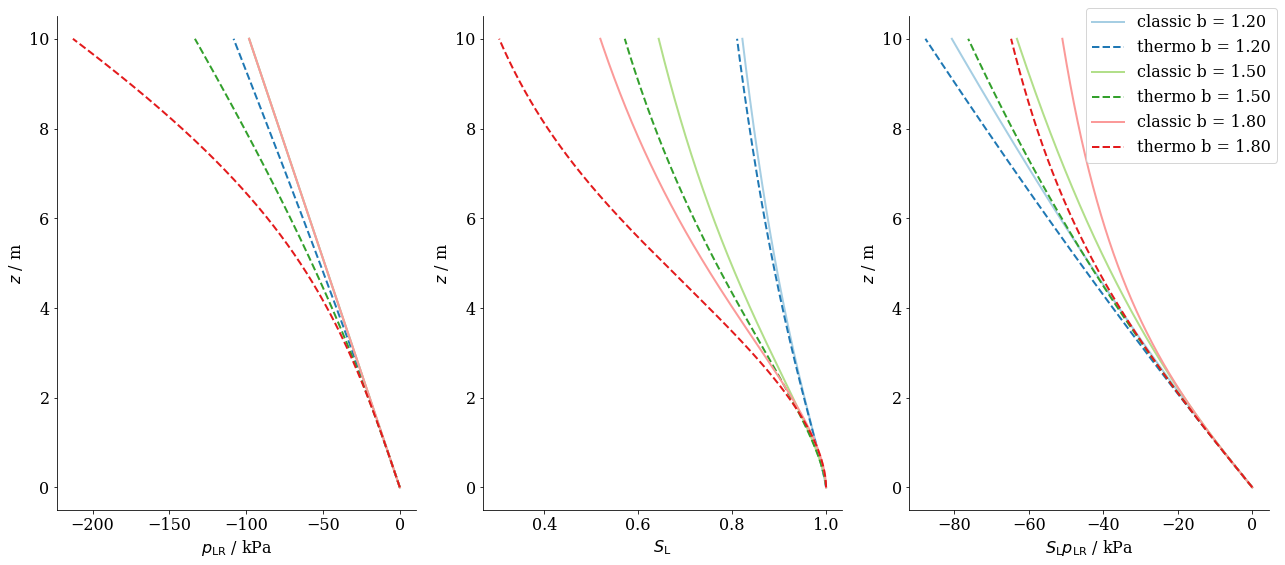

In [23]:
plot_results([1.2, 1.5, 1.8])

## Interpretation:

* All classic curves yield the same linear pressure profile peaking at 1 atm of capillary pressure.
* The extended model predicts higher capillary pressures and a non-linear profile.
* The profiles begin to diverge in the unsaturated regime (once air entry pressures are exceeded).
* The smaller the retention capacity (i.e. the shallower the $p_\text{cap}-S_\text{L}$ curve, the higher $b$), the lower the saturation in the upper soil layer, and the larger the influence of the new term on the pressure and saturation profile.
* The predicted saturation profiles are also lower because they are fed higher capillary pressures.
* The product $S_\text{L} p_\text{LR}$ has smaller deviations between both models.
* Thus, the extended term leads to a coupling of the $p_\text{cap}-S_\text{L}$ profiles in the soil layer. In the classical model, the capillary pressure profile is independent of the retention curve, while with the extended model there is now a dependency.

## Equilibrium pressure gradient

We change the last assumption:
* One-dimensional problem, $z$ points upward and starts at the groundwater table, so that $b=-g$

to a gravity-free setting:
* Let the experiment be such that gravitational forces play no role

Hence, we arrive at:

\begin{align*}
    0 &= \text{grad}\,p_\text{LR} - \frac{p_\text{cap}}{S_\text{L}} \text{grad}\,S_\text{L}
    \
    \frac{\partial p_\text{LR}}{\partial z} &= - \frac{p_\text{LR}}{S_\text{L}} \frac{\partial S_\text{L}}{\partial z} = \frac{p_\text{LR}}{S_\text{L}} \frac{\partial S_\text{L}}{\partial p_\text{cap}}\frac{\partial p_\text{LR}}{\partial z}
    \
    0 &= \frac{\partial p_\text{LR}}{\partial z} \left( 1 - \frac{p_\text{LR}}{S_\text{L}} \frac{\partial S_\text{L}}{\partial p_\text{cap}} \right)
\end{align*}

This leaves two possible solutions: a vanishing pressure gradient corresponding to the classical result:

$$
    \frac{\partial p_\text{LR}}{\partial z} = 0
$$

The second solution would be

\begin{align*}
    1 &= -\frac{p_\text{cap}}{S_\text{L}} \frac{\partial S_\text{L}}{\partial p_\text{cap}}
    \
    \frac{\text{d}p_\text{cap}}{p_\text{cap}} &= - \frac{\text{d}S_\text{L}}{S_\text{L}}
    \
    \left. \ln \bar{p}_\text{cap} \right|_{p_\text{b}}^{p_\text{cap}} &= - \left. \ln \bar{S}_\text{L} \right|_{1}^{S_\text{L}}
\end{align*}

which yields:

$$
    S_\text{L} = \frac{p_\text{b}}{p_\text{cap}} \ \text{with} \ p_\text{cap} \geq p_\text{b}
$$

which is a Brooks-Corey formulation with $\lambda = 1$:


In [13]:
def plot_input(pb=[1,10,100]):
    fig, ax = plt.subplots()
    for p in pb:
        pc=np.logspace(np.log10(p),6,1000)
    
        S2 = lambda pcap: pc[0]/pcap
        ax.plot(S2(pc),pc,label=r'$p_\mathrm{b} = %.1f\,$Pa' %p)
    
    ax.set_yscale('log')
    ax.set_xlabel(r'$S_\mathrm{L}$')
    ax.set_ylabel(r'$p_\mathrm{cap}$ / Pa')

    fig.legend()
    fig.tight_layout();

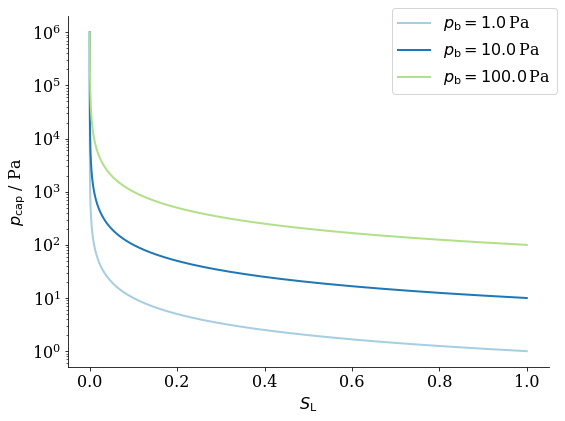

In [14]:
plot_input()

## Interpretation

Given an initial saturation profile across the soil specimen, an corresponding capillary (or liquid) pressure profile would result in line with this SWCC (BC with $\lambda = 1$). The respective liquid pressure gradient corresponding to said saturation distribution would
* result in flow in the classical model until a homogeneous saturation profile is reached.
* would be frozen in place in the extended model, i.e. no flow would occur.

## Next stebs

Stability analysis